In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8807127047785215488]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import h5py
import datetime
from sklearn.model_selection  import train_test_split,StratifiedKFold,cross_val_score
pd.set_option('display.max_columns', None)
from obspy.core import UTCDateTime
from obspy import read,read_inventory
import warnings
warnings.filterwarnings("ignore")

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image

from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [4]:
root_dir = "D:\Kuliah\Tugas Akhir\Tugas Akhir\Program_Tugas_Akhir\eews_ncheck_hard-shared_ortho_mtr_deeplearning\data"
file_dir = "D:\Kuliah\Tugas Akhir\Tugas Akhir\DataSet\EarthquakeCatalogJatimJateng\Jatim"
pick_dir = "D:\Kuliah\Tugas Akhir\Tugas Akhir\DataSet\EarthquakeCatalogJatimJateng\Jatim\Picking Jatim"

# **Pre Processing**

In [5]:
# CSV PATH
df = pd.read_csv(root_dir + '/data_618_final.csv')

# CHANGE COLUMN NAME
df['Depth(km)'] = df['Depth']
df.drop('Depth',axis=1,inplace=True)
df['foldername'] = df['filename'].apply(lambda x: x+'crop')
df['time'] = df['seconds']

df.head()

Unnamed: 0  No         filename        Date  Hr  Min  Sec       Lat  \
0           0   0  20090118_064750  18/01/2009   6   47   50  -9.13465   
1           1   1  20090119_171408  19/01/2009  17   14    9  -8.89110   
2           2   2  20090119_211141  19/01/2009  21   11   41  -8.62730   
3           3   3  20090120_123437  20/01/2009  12   34   34 -10.61305   
4           4   4  20090120_134800  20/01/2009  13   47   57 -10.56872   

      Long  Mag  GMJI  JAGI  PWJI  Unpick  Cluster  PA_start_real  flag_start  \
0  114.535  4.6     0     0     0       0        7            194         269   
1  111.814  3.1     0     1     0       1        4            200         275   
2  113.663  3.9     0     0     0       0       16            200         275   
3  114.893  4.9     1     0     0       1        7            197         272   
4  114.862  3.7     0     0     0       0        7            200         275   

   PA_start datetime  seconds           foldername   PA  cluster_class  \
0       275  00:15.5   15.510  20090118_064750crop  200              5   
1       275  00:17.0   16.970  20090119_171408crop  200              3   
2       275  00:14.9   14.946  20090119_211141crop  200             13   
3       275  00:33.7   33.725  20090120_123437crop  197              5   
4       275  00:33.2   33.156  20090120_134800crop  200              5   

   norm_lat  norm_long  norm_magnitude  norm_depth  Depth(km)    time  
0  0.488562   0.857755        0.457143    0.090947     54.570  15.510  
1  0.538546   0.080548        0.028571    0.060838     36.888  16.970  
2  0.592686   0.608683        0.257143    0.155808     92.661  14.946  
3  0.185149   0.960011        0.542857    0.092534     55.502  33.725  
4  0.194247   0.951157        0.200000    0.072366     43.658  33.156

In [6]:
# SELECT DATA BY A NUMBER OF CLUSTER
minimum_gempa = 1
selected_clusters =  [c for c in sorted(df.Cluster.unique()) if len(df[df.Cluster==c])>=minimum_gempa]
df = df[df.Cluster.isin(selected_clusters)]

# CREATE CLUSTER CLASS
make_cluster_class = {}
for i in range(len(selected_clusters)):
    make_cluster_class[selected_clusters[i]] = i
    print('Cluster',selected_clusters[i], '- Class',i)

df['cluster_class'] = df['Cluster'].apply(lambda x: make_cluster_class[x])

print('\nAfter selected:',df.shape[0],'row')

Cluster 1 - Class 0
Cluster 2 - Class 1
Cluster 3 - Class 2
Cluster 4 - Class 3
Cluster 6 - Class 4
Cluster 7 - Class 5
Cluster 8 - Class 6
Cluster 9 - Class 7
Cluster 11 - Class 8
Cluster 12 - Class 9
Cluster 13 - Class 10
Cluster 14 - Class 11
Cluster 15 - Class 12
Cluster 16 - Class 13
Cluster 17 - Class 14

After selected: 618 row


In [7]:
make_cluster_class

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 6: 4,
 7: 5,
 8: 6,
 9: 7,
 11: 8,
 12: 9,
 13: 10,
 14: 11,
 15: 12,
 16: 13,
 17: 14}

In [8]:
print('BEFORE NORMALIZATION')
print('Max Lat:',df['Lat'].max(),'\t\tMin Lat:',df['Lat'].min())
print('Max Long:',df['Long'].max(),'\tMin Long:',df['Long'].min())
print('Max Depth(km):',df['Depth(km)'].max(),'\tMin Depth(km):',df['Depth(km)'].min())
print('Max Mag:',df['Mag'].max(),'\t\tMin Mag:',df['Mag'].min())
print('Max Time:',df['time'].max(),'\t\tMin Time:',df['time'].min())

BEFORE NORMALIZATION
Max Lat: -6.64264 		Min Lat: -11.5152
Max Long: 115.033 	Min Long: 111.532
Max Depth(km): 588.426 	Min Depth(km): 1.16
Max Mag: 6.5 		Min Mag: 3.0
Max Time: 74.122 		Min Time: 4.502


In [9]:
### NORMALIZATION
#coef_norm_lat = 3 
coef_norm_lat = df['Lat'].max() - df['Lat'].min() # min-max-normalization 0-1 

#coef_norm_long = 3
coef_norm_long = df['Long'].max() - df['Long'].min() # min-max-normalization 0-1

#coef_norm_mag = 6
coef_norm_magnitude = df['Mag'].max() - df['Mag'].min() # min-max-normalization 0-1

#coef_norm_mag = 6
coef_norm_depth = df['Depth(km)'].max() - df['Depth(km)'].min() # min-max-normalization 0-1

#coef_norm_time = 6
coef_norm_time = df['time'].max() - df['time'].min() # min-max-normalization 0-1

df['norm_lat'] = df['Lat'].apply(lambda x: (x - df['Lat'].min()) / coef_norm_lat)
df['norm_long'] = df['Long'].apply(lambda x: (x - df['Long'].min()) / coef_norm_long)
df['norm_magnitude'] = df['Mag'].apply(lambda x: (x - df['Mag'].min()) / coef_norm_magnitude)
df['norm_depth'] = df['Depth(km)'].apply(lambda x: (x - df['Depth(km)'].min()) / coef_norm_depth)
df['norm_time'] = df['time'].apply(lambda x: (x - df['time'].min()) / coef_norm_time)

In [10]:
print('AFTER NORMALIZATION')
print('Max norm_lat:',df['norm_lat'].max(),'\tMin norm_lat:',df['norm_lat'].min())
print('Max norm_long:',df['norm_long'].max(),'\tMin norm_long:',df['norm_long'].min())
print('Max norm_magnitude:',df['norm_magnitude'].max(),'\tMin norm_magnitude:',df['norm_magnitude'].min())
print('Max norm_depth:',df['norm_depth'].max(),'\tMin norm_depth:',df['norm_depth'].min())
print('Max norm_time:',df['norm_time'].max(),'\tMin norm_time:',df['norm_time'].min())

AFTER NORMALIZATION
Max norm_lat: 1.0 	Min norm_lat: 0.0
Max norm_long: 1.0 	Min norm_long: 0.0
Max norm_magnitude: 1.0 	Min norm_magnitude: 0.0
Max norm_depth: 1.0 	Min norm_depth: 0.0
Max norm_time: 1.0 	Min norm_time: 0.0


In [11]:
test_df = pd.read_csv(root_dir + '/data_test_val_final.csv')
test_df = df[df.foldername.isin(test_df.foldername.values)]
train_df = df[~df.foldername.isin(test_df.foldername.values)]

In [12]:
from scipy.signal import butter, lfilter, filtfilt
def butter_bandpass(lowcut, highcut, fs, order):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

#band pass filter with filtfilt
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  # y = lfilter(b, a, data)
  y =filtfilt(b, a, data)
  return y

def generate_dataset(filename):
    st = read(f"{file_dir}/{filename}.mseed")
    column = ["id","network","station","location","channel","starttime","endtime","sampling_rate",
              "delta","npts","calib","_format","dataquality","number_of_records","encoding","byteorder",
             "record_length","filesize","data"]
    df = pd.DataFrame(columns=column, dtype=object)
    for i in range(len(st)):
        tr = st[i]
        data = []
        for j in range(1,12):
            data+=[tr.stats[column[j]]]
        for j in range(12,18):
            data+=[tr.stats.mseed[column[j]]]
        data += [tr.data]
        #with id
        data = [filename + "_" +tr.stats.station] + data
        df.loc[i] = data
        
    #file pick to csv
    column = ["station", "c1" , "channel","c2","wave","c3","time","c4","c5","c6","c7","c8"]
    df_pick = pd.DataFrame(columns=column, dtype=object)
    f = open(f"{pick_dir}/{filename}.pick", "r")
    pick_list = f.read().split("\n")
    for i,pick in enumerate(pick_list):
        if(pick !=""):
            pick = pick.split(" ")
            data = pick[0:6]
            data += [UTCDateTime(pick[6][0:4]+"-"+pick[6][4:6]+'-'+pick[6][6:8]+"T"+pick[7][0:2]+":"+pick[7][2:4]+":"+pick[8] + "Z")]
            data +=pick[9:14]
            df_pick.loc[i] = data
    #get earthquake data
    list_station = df_pick.station.unique()
    list_station = sorted(list_station) # sort by name
    #check pick, if empty, copy pick from coupled event
    for stasiun_check in ["GMJI","JAGI","PWJI"]: 
        if stasiun_check not in list_station: # check station
            data_pick = df_pick[df_pick.station==[ station_pick for station_pick in list_station if station_pick in ["GMJI","JAGI","PWJI"]][0] ]
            for s_iter in range(len(data_pick)):
                data_pick.station = stasiun_check
            df_pick = pd.concat([df_pick,data_pick]).reset_index(drop=True)
    list_station = df_pick.station.unique()
    df_gempa = df.copy()
    df_gempa["gempa"] = df.station.apply(lambda p: p in list_station)
    df_gempa = df_gempa[df_gempa.gempa == True].sort_values(["station","channel"])
    
    #create dataset       
    column = ["starttime","endtime","npts",
             "E_waveform","N_waveform","Z_waveform","p_arrival_time","s_arrival_time","p_arrival_sample","s_arrival_sample"]
    dataset = pd.DataFrame(columns=column, dtype=object)
    df_gempa = df_gempa[(df_gempa.station == "GMJI") | (df_gempa.station == "PWJI") | (df_gempa.station == "JAGI")]
    for i in df_gempa.index[::3]:
        #get all
        starttime = max(df.starttime[i],df.starttime[i+1],df.starttime[i+2])
        endtime = min(df.endtime[i],df.endtime[i+1],df.endtime[i+2])
        if(df.channel[i] == "BHE"):
          E_waveform = df.data[i]
        else:
          continue
        if(df.channel[i+1] == "BHN"):
          N_waveform = df.data[i+1]
        else:
          continue
        if(df.channel[i+2] == "BHZ"):
          Z_waveform = df.data[i+2]
        else:
          continue
        #set starttime dan endtime
        E_waveform = E_waveform[int(round((starttime - df.starttime[i])*df.sampling_rate[i])):int(len(E_waveform) - (round((df.endtime[i] - endtime)*df.sampling_rate[i])))]
        N_waveform = N_waveform[int(round((starttime - df.starttime[i+1])*df.sampling_rate[i+1])):int(len(N_waveform) - (round((df.endtime[i+1] - endtime)*df.sampling_rate[i+1])))]
        Z_waveform = Z_waveform[int(round((starttime - df.starttime[i+2])*df.sampling_rate[i+2])):int(len(Z_waveform) - (round((df.endtime[i+2] - endtime)*df.sampling_rate[i+2])))]
        
        #bandpass filter
        fs = df.sampling_rate[i]
        lowcut = 1.0
        highcut = 5.0
        order = 5
        E_waveform = butter_bandpass_filter(E_waveform, lowcut, highcut, fs,order)                                  
        N_waveform = butter_bandpass_filter(N_waveform, lowcut, highcut, fs,order)
        Z_waveform = butter_bandpass_filter(Z_waveform, lowcut, highcut, fs,order)
        
        #normalization
        E_waveform = E_waveform/np.amax(np.abs(E_waveform))
        N_waveform = N_waveform/np.amax(np.abs(N_waveform))
        Z_waveform = Z_waveform/np.amax(np.abs(Z_waveform))
        
        #get p_arrival dan s_arrival
        s_arrival_time = UTCDateTime(str(df_pick[(df_pick.station == df_gempa.station[i]) & (df_pick.wave == "S")].time)[5:32])
        p_arrival_time = UTCDateTime(str(df_pick[(df_pick.station == df_gempa.station[i]) & (df_pick.wave == "P")].time)[5:32])
        s_arrival_sample = int(round((s_arrival_time - starttime)*df.sampling_rate[i]))
        p_arrival_sample = int(round((p_arrival_time - starttime)*df.sampling_rate[i]))
        if((len(E_waveform) == len(N_waveform)) & (len(E_waveform) == len(Z_waveform)) &(len(E_waveform)!=0)):
          dataset.loc[i] = [starttime,endtime,len(E_waveform),E_waveform,N_waveform,Z_waveform,p_arrival_time,s_arrival_time,
                          p_arrival_sample,s_arrival_sample]
        else:
          # print(df_gempa.station[i] , len(E_waveform),len(N_waveform),len(Z_waveform))
          length = min(len(E_waveform),len(N_waveform),len(Z_waveform))
          E_waveform = E_waveform[:length]
          N_waveform = N_waveform[:length]
          Z_waveform = Z_waveform[:length]
          dataset.loc[i] = [starttime,endtime,len(E_waveform),E_waveform,N_waveform,Z_waveform,p_arrival_time,s_arrival_time,
                          p_arrival_sample,s_arrival_sample]
    dataset[['id', 'network', 'station', 'location','sampling_rate', 'delta',
                             'calib']] = df_gempa[['id', 'network', 'station', 'location','sampling_rate', 'delta',
                             'calib']].loc[::3]
    dataset = dataset.set_index("id")
    return dataset

In [13]:
dataset = generate_dataset('20090120_123437')
dataset

starttime  \
id                                                  
20090120_123437_GMJI  2009-01-20T12:32:36.610000Z   
20090120_123437_JAGI  2009-01-20T12:32:36.869538Z   
20090120_123437_PWJI  2009-01-20T12:32:32.630000Z   

                                          endtime   npts  \
id                                                         
20090120_123437_GMJI  2009-01-20T12:49:39.530000Z  25574   
20090120_123437_JAGI  2009-01-20T12:49:39.469538Z  20453   
20090120_123437_PWJI  2009-01-20T12:49:41.430000Z  25721   

                                                             E_waveform  \
id                                                                        
20090120_123437_GMJI  [0.001041547709039628, -0.0032313379165818906,...   
20090120_123437_JAGI  [-6.595429915607221e-05, 0.0008026075409074609...   
20090120_123437_PWJI  [-0.00016024263927969716, 0.018103044908932556...   

                                                             N_waveform  \
id                                                                        
20090120_123437_GMJI  [0.0003138719025506559, -0.0005108980013967531...   
20090120_123437_JAGI  [-7.313716666031448e-05, -0.000123694870970404...   
20090120_123437_PWJI  [-1.0834158667365901e-05, -0.00396178147140404...   

                                                             Z_waveform  \
id                                                                        
20090120_123437_GMJI  [0.0007094994161508941, 0.00552109534412947, 0...   
20090120_123437_JAGI  [9.232378170966277e-05, -0.0010643671460883585...   
20090120_123437_PWJI  [0.0007915666668372975, 0.02406146538789623, 0...   

                                   p_arrival_time  \
id                                                  
20090120_123437_GMJI  2009-01-20T12:35:10.725000Z   
20090120_123437_JAGI  2009-01-20T12:35:10.725000Z   
20090120_123437_PWJI  2009-01-20T12:35:35.032000Z   

                                   s_arrival_time p_arrival_sample  \
id                                                                   
20090120_123437_GMJI  2009-01-20T12:35:38.090000Z             3853   
20090120_123437_JAGI  2009-01-20T12:35:38.090000Z             3077   
20090120_123437_PWJI  2009-01-20T12:36:20.186000Z             4560   

                     s_arrival_sample network station location  sampling_rate  \
id                                                                              
20090120_123437_GMJI             4537      IA    GMJI                    25.0   
20090120_123437_JAGI             3624      IA    JAGI                    20.0   
20090120_123437_PWJI             5689      IA    PWJI                    25.0   

                      delta  calib  
id                                  
20090120_123437_GMJI   0.04    1.0  
20090120_123437_JAGI   0.05    1.0  
20090120_123437_PWJI   0.04    1.0

-----------------------------------------------------------------------------------------------

In [14]:
# For Python 2 compatibility.
from __future__ import division, print_function

def print_list(values):
    print('[' + ', '.join(format(value, '.3f') for value in values) + ']')

def interpolate(lst, fi):
    i, f = int(fi // 1), fi % 1  # Split floating-point index into whole & fractional parts.
    j = i+1 if f > 0 else i  # Avoid index error.
    return (1-f) * lst[i] + f * lst[j]


def letInterpolate(inp, new_len):
  delta = (len(inp)-1) / (new_len-1)
  outp = [interpolate(inp, i*delta) for i in range(new_len)]
  return outp



In [15]:
def cek_sampling(sampling):
  if sampling == 25:
    return sampling*4
  elif sampling == 20:
    return sampling*5

In [16]:
def cek_rate(sampling):
  if sampling == 25:
    return 4
  elif sampling == 20:
    return 5

--------------------------------

In [18]:
data_per_s = 0
trace_gmji = []
PA_realg = dataset.iloc[1].p_arrival_sample
srg = dataset.iloc[1].sampling_rate
col_E = []
col_N = []
col_Z = []
for i in range((int(PA_realg-srg*15))-1 , ((int(PA_realg+srg*15))-1)):
    col_feature = []
    col_E.append(dataset.iloc[1].E_waveform[i])
    col_N.append(dataset.iloc[1].N_waveform[i])
    col_Z.append(dataset.iloc[1].Z_waveform[i])
    trace_gmji.append(col_feature)

In [19]:
trace_gmji = []
for i in range(len(col_E)):
  col_feature = []
  col_feature.append(col_E[i])
  col_feature.append(col_N[i])
  col_feature.append(col_Z[i])
  trace_gmji.append(col_feature)


In [20]:
len(col_E)

600

In [23]:
trace = np.array(trace_gmji)
time = np.arange( 0, 750 / dataset.iloc[0].sampling_rate, 0.05)


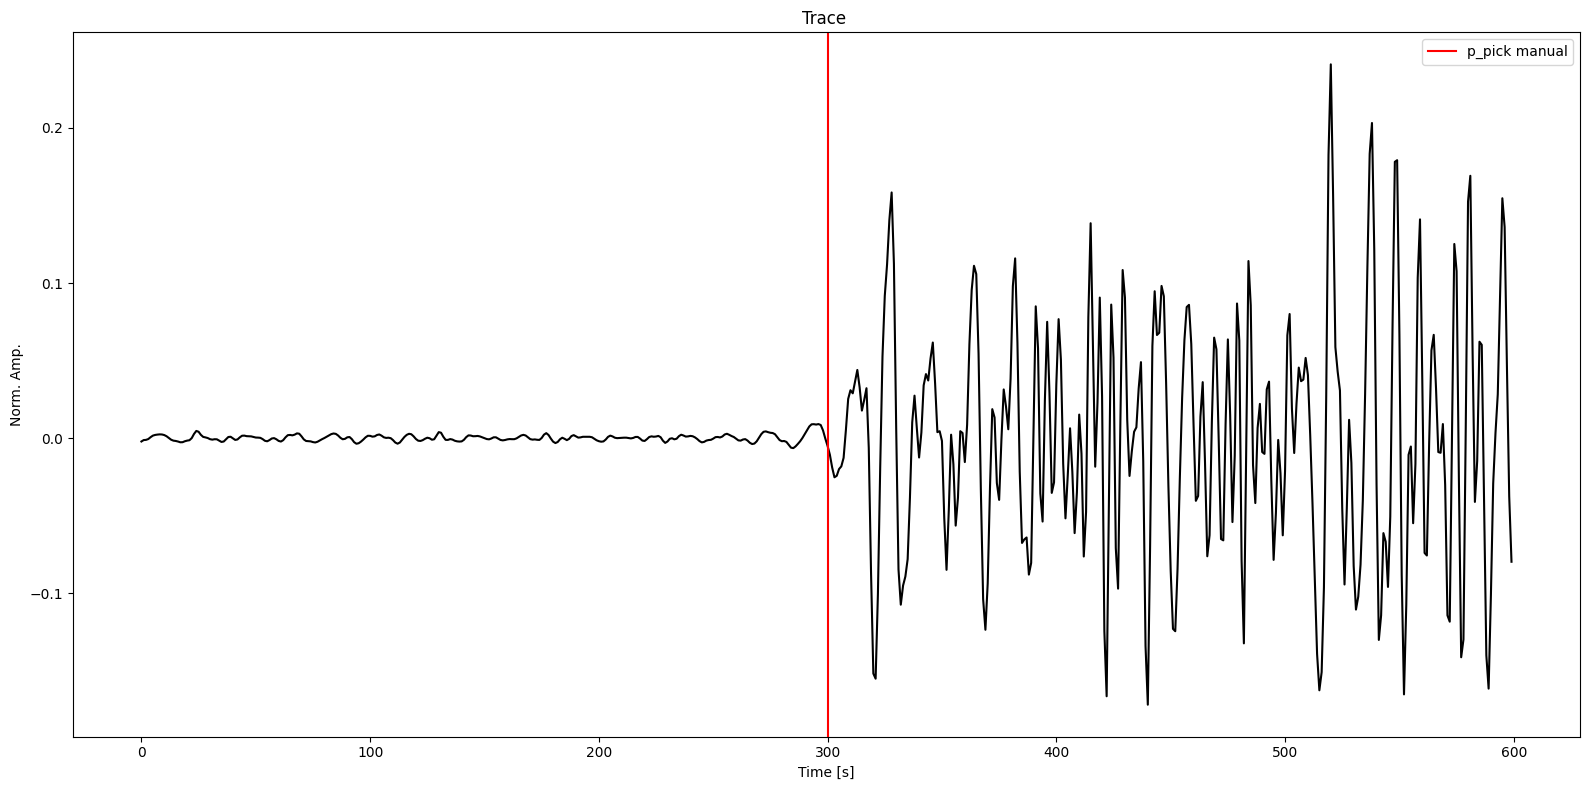

In [21]:
rows = 1
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
axes.set_title("Trace ")
axes.plot(col_E, color = 'black')
axes.axvline(300 , color = 'red', label = "p_pick manual")


axes.set_xlabel("Time [s]")

axes.set_ylabel('Norm. Amp.')
axes.legend()
    
plt.tight_layout()

In [25]:
dataset.iloc[0].p_arrival_sample

3853

In [26]:
def generate_waveforms(dataset, lst_set):
  data_per_s = 0
  trace_gmji = []
  PA_realg = dataset.iloc[0].p_arrival_sample
  print(PA_realg)
  srg = dataset.iloc[0].sampling_rate
  data_per_s = cek_rate(srg)
  
  for i in range((int(PA_realg-data_per_s))-1, (int(PA_realg+data_per_s))-1):
    col_feature = []
    col_feature.append(dataset.iloc[0].E_waveform[i])
    col_feature.append(dataset.iloc[0].N_waveform[i])
    col_feature.append(dataset.iloc[0].Z_waveform[i])
    trace_gmji.append(col_feature)

  trace_jagi = []
  PA_realj = dataset.iloc[1].p_arrival_sample
  srj = dataset.iloc[1].sampling_rate
  data_per_s = cek_sampling(srj)
  for i in range((int(PA_realj-data_per_s))-1, (int(PA_realj+data_per_s))-1):
    col_feature = []
    col_feature.append(dataset.iloc[1].E_waveform[i])
    col_feature.append(dataset.iloc[1].N_waveform[i])
    col_feature.append(dataset.iloc[1].Z_waveform[i])
    trace_jagi.append(col_feature)

  trace_pwji = []
  PA_realp = dataset.iloc[2].p_arrival_sample
  srp = dataset.iloc[2].sampling_rate
  data_per_s = cek_sampling(srp)
  for i in range((int(PA_realg-data_per_s))-1, (int(PA_realg+data_per_s))-1):
    col_feature = []
    col_feature.append(dataset.iloc[2].E_waveform[i])
    col_feature.append(dataset.iloc[2].N_waveform[i])
    col_feature.append(dataset.iloc[2].Z_waveform[i])
    trace_pwji.append(col_feature)

  lst_set.append(trace_gmji)
  lst_set.append(trace_jagi)
  lst_set.append(trace_pwji)

In [22]:
def generate_waveforms_with_interpolate(dataset, lst_set):
  data_per_s = 0
  trace_gmji = []
  PA_realg = dataset.iloc[0].p_arrival_sample
  srg = dataset.iloc[0].sampling_rate
  data_per_s = cek_rate(srg)
  
  col_E = []
  col_N = []
  col_Z = []
  for i in range((int(PA_realg-srg*15))-1 , ((int(PA_realg+srg*15))-1)):
      col_E.append(dataset.iloc[0].E_waveform[i])
      col_N.append(dataset.iloc[0].N_waveform[i])
      col_Z.append(dataset.iloc[0].Z_waveform[i])
  rate_samp = cek_rate(srg)
  col_E = letInterpolate(col_E, len(col_E)*rate_samp)
  col_N = letInterpolate(col_N, len(col_N)*rate_samp)
  col_Z = letInterpolate(col_Z, len(col_Z)*rate_samp)
  for i in range(len(col_E)):
    col_feature = []
    col_feature.append(col_E[i])
    col_feature.append(col_N[i])
    col_feature.append(col_Z[i])
    trace_gmji.append(col_feature)

  trace_jagi = []
  PA_realj = dataset.iloc[1].p_arrival_sample
  srj = dataset.iloc[1].sampling_rate
  data_per_s = cek_rate(srj)

  col_E = []
  col_N = []
  col_Z = []
  for i in range((int(PA_realj-srj*15))-1 , ((int(PA_realj+srj*15))-1)):
      col_E.append(dataset.iloc[1].E_waveform[i])
      col_N.append(dataset.iloc[1].N_waveform[i])
      col_Z.append(dataset.iloc[1].Z_waveform[i])
  rate_samp = cek_rate(srj)
  col_E = letInterpolate(col_E, len(col_E)*rate_samp)
  col_N = letInterpolate(col_N, len(col_N)*rate_samp)
  col_Z = letInterpolate(col_Z, len(col_Z)*rate_samp)
  for i in range(len(col_E)):
    col_feature = []
    col_feature.append(col_E[i])
    col_feature.append(col_N[i])
    col_feature.append(col_Z[i])
    trace_jagi.append(col_feature)

  trace_pwji = []
  PA_realp = dataset.iloc[2].p_arrival_sample
  srp = dataset.iloc[2].sampling_rate
  data_per_s = cek_rate(srp)
  col_E = []
  col_N = []
  col_Z = []
  for i in range((int(PA_realp-srp*15))-1 , ((int(PA_realp+srp*15))-1)):
      col_E.append(dataset.iloc[2].E_waveform[i])
      col_N.append(dataset.iloc[2].N_waveform[i])
      col_Z.append(dataset.iloc[2].Z_waveform[i])
  rate_samp = cek_rate(srp)
  col_E = letInterpolate(col_E, len(col_E)*rate_samp)
  col_N = letInterpolate(col_N, len(col_N)*rate_samp)
  col_Z = letInterpolate(col_Z, len(col_Z)*rate_samp)
  for i in range(len(col_E)):
    col_feature = []
    
    col_feature.append(col_E[i])
    col_feature.append(col_N[i])
    col_feature.append(col_Z[i])
    trace_pwji.append(col_feature)

  lst_set.append(trace_gmji)
  lst_set.append(trace_jagi)
  lst_set.append(trace_pwji)


In [23]:
def generate_p_arrival(dataset, lst_p_arrive):
  #gmji
  lst_p_arrive.append(dataset.iloc[0].p_arrival_sample*cek_rate(dataset.iloc[0].sampling_rate))
  print(lst_p_arrive)
  #jagi
  lst_p_arrive.append(dataset.iloc[1].p_arrival_sample*cek_rate(dataset.iloc[1].sampling_rate))
  print(lst_p_arrive)
  #pwji
  lst_p_arrive.append(dataset.iloc[2].p_arrival_sample*cek_rate(dataset.iloc[2].sampling_rate))
  print(lst_p_arrive)

In [24]:
data_setpoint = []

In [25]:
df.loc[0:4]

Unnamed: 0  No         filename        Date  Hr  Min  Sec       Lat  \
0           0   0  20090118_064750  18/01/2009   6   47   50  -9.13465   
1           1   1  20090119_171408  19/01/2009  17   14    9  -8.89110   
2           2   2  20090119_211141  19/01/2009  21   11   41  -8.62730   
3           3   3  20090120_123437  20/01/2009  12   34   34 -10.61305   
4           4   4  20090120_134800  20/01/2009  13   47   57 -10.56872   

      Long  Mag  GMJI  JAGI  PWJI  Unpick  Cluster  PA_start_real  flag_start  \
0  114.535  4.6     0     0     0       0        7            194         269   
1  111.814  3.1     0     1     0       1        4            200         275   
2  113.663  3.9     0     0     0       0       16            200         275   
3  114.893  4.9     1     0     0       1        7            197         272   
4  114.862  3.7     0     0     0       0        7            200         275   

   PA_start datetime  seconds           foldername   PA  cluster_class  \
0       275  00:15.5   15.510  20090118_064750crop  200              5   
1       275  00:17.0   16.970  20090119_171408crop  200              3   
2       275  00:14.9   14.946  20090119_211141crop  200             13   
3       275  00:33.7   33.725  20090120_123437crop  197              5   
4       275  00:33.2   33.156  20090120_134800crop  200              5   

   norm_lat  norm_long  norm_magnitude  norm_depth  Depth(km)    time  \
0  0.488562   0.857755        0.457143    0.090947     54.570  15.510   
1  0.538546   0.080548        0.028571    0.060838     36.888  16.970   
2  0.592686   0.608683        0.257143    0.155808     92.661  14.946   
3  0.185149   0.960011        0.542857    0.092534     55.502  33.725   
4  0.194247   0.951157        0.200000    0.072366     43.658  33.156   

   norm_time  
0   0.158115  
1   0.179086  
2   0.150014  
3   0.419750  
4   0.411577

In [26]:
train_df

Unnamed: 0   No         filename        Date  Hr  Min  Sec       Lat  \
0             0    0  20090118_064750  18/01/2009   6   47   50  -9.13465   
1             1    1  20090119_171408  19/01/2009  17   14    9  -8.89110   
2             2    2  20090119_211141  19/01/2009  21   11   41  -8.62730   
3             3    3  20090120_123437  20/01/2009  12   34   34 -10.61305   
4             4    4  20090120_134800  20/01/2009  13   47   57 -10.56872   
..          ...  ...              ...         ...  ..  ...  ...       ...   
608         658  707  20170723_124310  23/07/2017  12   43   10  -6.81839   
612         662  711  20170808_035626    8/8/2017   3   56   26 -10.84090   
613         663  712  20170818_084429  18/08/2017   8   44   29 -11.35369   
614         664  713  20170824_053322  24/08/2017   5   33   22  -9.35305   
615         665  714  20170901_034735    1/9/2017   3   47   35 -11.35750   

        Long  Mag  GMJI  JAGI  PWJI  Unpick  Cluster  PA_start_real  \
0    114.535  4.6     0     0     0       0        7            194   
1    111.814  3.1     0     1     0       1        4            200   
2    113.663  3.9     0     0     0       0       16            200   
3    114.893  4.9     1     0     0       1        7            197   
4    114.862  3.7     0     0     0       0        7            200   
..       ...  ...   ...   ...   ...     ...      ...            ...   
608  112.533  3.2     1     1     0       2       12            201   
612  113.051  4.3     1     0     0       1        3            172   
613  112.160  4.6     0     0     1       1        9            200   
614  112.741  3.6     0     0     0       0        1            198   
615  112.808  4.7     0     0     0       0        9            200   

     flag_start  PA_start datetime  seconds           foldername   PA  \
0           269       275  00:15.5   15.510  20090118_064750crop  200   
1           275       275  00:17.0   16.970  20090119_171408crop  200   
2           275       275  00:14.9   14.946  20090119_211141crop  200   
3           272       275  00:33.7   33.725  20090120_123437crop  197   
4           275       275  00:33.2   33.156  20090120_134800crop  200   
..          ...       ...      ...      ...                  ...  ...   
608         276       275  00:24.5   24.519  20170723_124310crop  201   
612         247       275  00:42.0   42.026  20170808_035626crop  172   
613         275       275  00:49.4   49.359  20170818_084429crop  200   
614         273       275  00:21.4   21.440  20170824_053322crop  200   
615         275       275  00:49.5   49.533  20170901_034735crop  200   

     cluster_class  norm_lat  norm_long  norm_magnitude  norm_depth  \
0                5  0.488562   0.857755        0.457143    0.090947   
1                3  0.538546   0.080548        0.028571    0.060838   
2               13  0.592686   0.608683        0.257143    0.155808   
3                5  0.185149   0.960011        0.542857    0.092534   
4                5  0.194247   0.951157        0.200000    0.072366   
..             ...       ...        ...             ...         ...   
608              9  0.963931   0.285918        0.057143    0.144892   
612              2  0.138387   0.433876        0.371429    0.091913   
613              7  0.033147   0.179377        0.457143    0.110466   
614              0  0.443740   0.345330        0.171429    0.010692   
615              7  0.032365   0.364467        0.485714    0.102584   

     Depth(km)    time  norm_time  
0      54.5700  15.510   0.158115  
1      36.8880  16.970   0.179086  
2      92.6610  14.946   0.150014  
3      55.5020  33.725   0.419750  
4      43.6580  33.156   0.411577  
..         ...     ...        ...  
608    86.2500  24.519   0.287518  
612    55.1371  42.026   0.538983  
613    66.0330  49.359   0.644312  
614     7.4390  21.440   0.243292  
615    61.4040  49.533   0.646811  

[556 rows x 30 columns]

In [27]:
##generate dataset untuk p_arrive dan waveform
x_train = []
y_cluster_train = []
y_lat_train = []
y_long_train = []
y_depth_train = []
y_magnitude_train = []
y_time_train = []
run_total = 0
for index, row in train_df.iterrows():
  data_setpoint = generate_dataset(row["filename"])
  ###lst_total.append(generate_waveform(data_setpoint))
  generate_waveforms_with_interpolate(data_setpoint, x_train)
  for enz in range(3):
    y_cluster_train.append(row["cluster_class"])
    y_lat_train.append(row["norm_lat"])
    y_long_train.append(row["norm_long"])
    y_depth_train.append(row["norm_depth"])
    y_magnitude_train.append(row["norm_magnitude"])
    y_time_train.append(row["norm_time"])
  run_total += 1
  print(run_total)

y_cluster_train = np.array(y_cluster_train)
y_lat_train = np.array(y_lat_train)
y_long_train = np.array(y_long_train)
y_depth_train = np.array(y_depth_train)
y_magnitude_train = np.array(y_magnitude_train)
y_time_train = np.array(y_time_train)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [28]:
x_test = []
y_cluster_test = []
y_lat_test = []
y_long_test = []
y_depth_test = []
y_magnitude_test = []
y_time_test = []
run_total = 0
for index, row in test_df.iterrows():
  data_setpoint = generate_dataset(row["filename"])
  ###lst_total.append(generate_waveform(data_setpoint))
  generate_waveforms_with_interpolate(data_setpoint, x_test)
  for enz in range(3):
    y_cluster_test.append(row["cluster_class"])
    y_lat_test.append(row["norm_lat"])
    y_long_test.append(row["norm_long"])
    y_depth_test.append(row["norm_depth"])
    y_magnitude_test.append(row["norm_magnitude"])
    y_time_test.append(row["norm_time"])
  run_total += 1
  print(run_total)

y_cluster_test = np.array(y_cluster_test)
y_lat_test = np.array(y_lat_test)
y_long_test = np.array(y_long_test)
y_depth_test = np.array(y_depth_test)
y_magnitude_test = np.array(y_magnitude_test)
y_time_test = np.array(y_time_test)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


In [30]:
tes = np.array(x_test)
tes.shape

(186, 3000, 3)

In [29]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [31]:
print(tes.shape)
print(y_cluster_test.shape)
print(y_lat_test.shape)
print(y_long_test.shape)
print(y_depth_test.shape)
print(y_magnitude_test.shape)
print(y_time_test.shape)

(186, 3000, 3)
(186,)
(186,)
(186,)
(186,)
(186,)
(186,)


In [ ]:
lst_p_arrive = []
run_total = 0
for i in range(5):
  '''data_setpoint = generate_dataset(df.loc[i, "filename"])
  generate_p_arrival(data_setpoint, lst_p_arrive)'''
  lst_p_arrive.append(1500)
  lst_p_arrive.append(1500)
  lst_p_arrive.append(1500)
  run_total += 1

In [39]:
import numpy as np

new_array = np.array(x_train)

np.save('data_1DCNN.npy', new_array)

In [ ]:
np.save('y_cluster.npy', y_cluster)
np.save('y_lat.npy', y_lat)
np.save('y_long.npy', y_long)
np.save('y_depth.npy', y_depth)
np.save('y_magnitude.npy', y_magnitude)
np.save('y_time.npy', y_time)

In [88]:
x_train = np.load(root_dir + '/data_1DCNN.npy',allow_pickle=True)

In [ ]:
x = np.array(new_array)
x.shape

(1854, 3000, 3)

In [41]:
num_traces = new_array.shape[0]
num_feat   = new_array.shape[2]
npts = new_array.shape[1]
print(num_traces)
print(num_feat)
print(npts)

1668
3
3000


In [42]:
import numpy as np

lst_p_arrive = np.array(lst_p_arrive)

np.save('lst_p_arrive.npy', lst_p_arrive)

NameError: ignored

In [ ]:
lst_p_arrive = np.array(lst_p_arrive)

In [ ]:
lst_p_arrive.shape

(15,)

# **Data Split**

# **CNN**

In [ ]:
import os
import numpy as np
import pandas as pd
from random import randint
from keras.layers import Input, Dense
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model

In [ ]:
# Hyperparameters 
batch_size = 256
epochs     = 400
filters    = [32, 64]
kernel_size = 6
pool_size = 2
padding = 'same'
hidden_act_fun = 'relu'
final_act_fun  = 'linear'
optimizer = 'adam'
loss_type = 'mean_squared_error' 
name = 'p_phase_picker'

## MODEL ##
# Input placeholder
input_trace = Input(shape=(x_train.shape[1], x_train.shape[2]))  
x = Conv1D(filters = filters[0], kernel_size = kernel_size, activation=hidden_act_fun, padding = padding)(input_trace)
x = MaxPooling1D(pool_size = pool_size, padding = padding)(x)
x = Conv1D(filters = filters[1], kernel_size = kernel_size, activation=hidden_act_fun, padding = padding)(x)
x = MaxPooling1D(pool_size = pool_size, padding = padding)(x)
cnn_feat = Flatten()(x)

x = Dense(units= 32, activation=hidden_act_fun)(cnn_feat)
x = BatchNormalization()(x)
x = Dense(units = 8, activation=hidden_act_fun)(x)
x = BatchNormalization()(x)
dense = Dense(units= 1, activation=final_act_fun)(x)

# Compile Model
p_phase_picker = Model(input_trace, dense, name = name)
p_phase_picker.compile(optimizer = optimizer, loss = loss_type)
p_phase_picker.summary()

Model: "p_phase_picker"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3000, 3)]         0         
                                                                 
 conv1d (Conv1D)             (None, 3000, 32)          608       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1500, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1500, 64)          12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 750, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 48000)          

In [ ]:
history = p_phase_picker.fit(x = x_train,
                            y = y_train,
                            epochs= epochs,
                            batch_size=batch_size,
                            validation_data=(x_val, y_val))


Epoch 1/400
1/1 [==============================] - 10s 10s/step - loss: 2250003.0000 - val_loss: 2249441.0000
Epoch 2/400
1/1 [==============================] - 0s 37ms/step - loss: 2249986.7500 - val_loss: 2249181.2500
Epoch 3/400
1/1 [==============================] - 0s 30ms/step - loss: 2249970.7500 - val_loss: 2248916.5000
Epoch 4/400
1/1 [==============================] - 0s 34ms/step - loss: 2249955.2500 - val_loss: 2248644.7500
Epoch 5/400
1/1 [==============================] - 0s 31ms/step - loss: 2249939.7500 - val_loss: 2248362.0000
Epoch 6/400
1/1 [==============================] - 0s 29ms/step - loss: 2249924.5000 - val_loss: 2248101.2500
Epoch 7/400
1/1 [==============================] - 0s 32ms/step - loss: 2249909.2500 - val_loss: 2247856.7500
Epoch 8/400
1/1 [==============================] - 0s 33ms/step - loss: 2249893.7500 - val_loss: 2247617.7500
Epoch 9/400
1/1 [==============================] - 0s 31ms/step - loss: 2249878.5000 - val_loss: 2247390.7500
Epoch 10/4

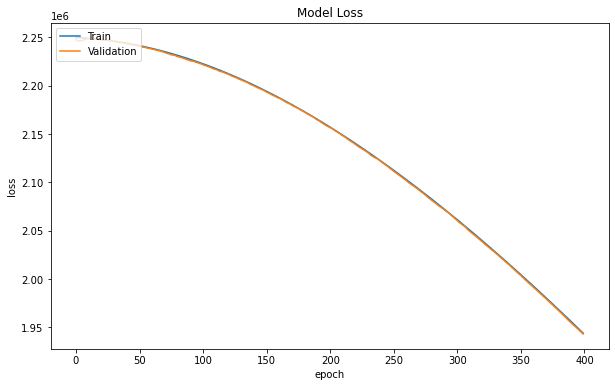

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,6))
axes.plot(history.history['loss'])
axes.plot(history.history['val_loss'])
axes.set_title('Model Loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['Train', 'Validation'], loc='upper left')


In [ ]:
train_loss = history.history['loss']
last_train_loss_value = train_loss[len(train_loss)-1]
val_loss = history.history['val_loss']
last_val_loss_value = val_loss[len(val_loss) - 1]

print(last_train_loss_value)
print(last_val_loss_value)

1943891.625
1943097.75


In [ ]:
x_val[0:1].shape

(1, 3000, 3)

In [ ]:
ML_SPICKS = p_phase_picker.predict(x_val)

12/12 [==============================] - 1s 54ms/step


In [ ]:
p_phase_picker.evaluate(x_val,  y_val, verbose=2)


12/12 - 1s - loss: 1943097.7500 - 585ms/epoch - 49ms/step


1943097.75

# MTR

In [58]:
print(x_train.shape)
print(x_test.shape)

(1668, 3000, 3)
(186, 3000, 3)


In [59]:
base="cnn"
output_names=["lat","long","depth","magnitude","time"]

In [60]:
model_name = base.upper() + "_multioutput_" if len(output_names)>1 else base.upper() + "_singleoutput_"  
model_name = model_name + "_".join(output_names) 

In [61]:
model_name

'CNN_multioutput_lat_long_depth_magnitude_time'

In [62]:
custom_name = "base1024-64" 

In [63]:
x_test.shape[1], 3

(3000, 3)

In [65]:
import keras
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

loss_function = 'mae'

def make_model(base="", output_names=[], custom_name=custom_name, loss_function=loss_function):
    m_ = None
    outputs = {}
    model_name = base.upper() + "_multioutput_" if len(output_names)>1 else base.upper() + "_singleoutput_"  
    model_name = model_name + "_".join(output_names) + "_"

    if base.lower()=="cnn":
        ### FOR CNN MODELS ###

        import keras
        base_model = Sequential()
        base_model.add(Conv1D(32, 3, input_shape=(x_test.shape[1], 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling1D(pool_size=2))

        base_model.add(Conv1D(64, 3))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling1D(pool_size=2))

        base_model.add(Conv1D(128, 3))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling1D(pool_size=2))

        base_model.add(Conv1D(256, 3))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling1D(pool_size=2))

### TUNNING SHARED-LAYER
        base_model.add(Flatten()) 
#         base_model.add(Dense(1024, kernel_initializer=keras.initializers.Orthogonal()))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
#         base_model.add(Dense(1024, kernel_initializer=keras.initializers.Orthogonal()))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
#         base_model.add(Dense(1024, kernel_initializer=keras.initializers.Orthogonal()))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
        m_ = base_model.output
        print(m_)

        ### --------------- ###




    else:
        print("Model Definition Error")

### NON-SHARED-LAYER
    for output_name in output_names:
        # multioutput
        m__ = m_
#         m__ = Dense(512,activation='relu')(m__) 
#         m__ = Dense(512,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m__) 
#         m__ = Dense(256,activation='relu')(m__) 
#         m__ = Dense(256,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m__) 
        outputs[output_name] = Dense(1, activation = 'linear', name = output_name)(m__)
        
    if len(output_names)==0: print("Outputs Definition Error")
    else:
        # single output 
        model = Model(inputs=base_model.input, outputs=[outputs[output_name] for output_name in output_names]) 
    
    model.compile(optimizer=Adam(1e-4),
                  loss=loss_function,   
                  metrics=[loss_function])
    
    model.summary()
    return model

In [66]:
model_name

'CNN_multioutput_lat_long_depth_magnitude_time'

In [67]:
model = make_model(base="cnn", output_names=["lat","long","depth","magnitude","time"])
y_train = {'lat':y_lat_train,'long':y_long_train,'depth':y_depth_train,'magnitude':y_magnitude_train,'time':y_time_train}
y_valid = {'lat':y_lat_test,'long':y_long_test,'depth':y_depth_test,'magnitude':y_magnitude_test,'time':y_time_test}
y_test = {'lat':y_lat_test,'long':y_long_test,'depth':y_depth_test,'magnitude':y_magnitude_test,'time':y_time_test}
model.name

Tensor("activation_14/Relu:0", shape=(None, 1024), dtype=float32)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_5_input (InputLayer)     (None, 3000, 3)      0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 2998, 32)     320         conv1d_5_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 2998, 32)     128         conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 2998, 32)     0           batch_normalization_5[0][0]      
__________________________

'model_2'

In [68]:
NSTEP = 20
Nbatch = 4

In [69]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.00001,
              verbose=1)

checkpoint = ModelCheckpoint( model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [72]:
history = model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=epochs, batch_size=batch_size)

Train on 1668 samples, validate on 186 samples
Epoch 1/20
1668/1668 [==============================] - 313s 188ms/step - loss: 1.5104 - lat_loss: 0.3022 - long_loss: 0.3534 - depth_loss: 0.2846 - magnitude_loss: 0.3032 - time_loss: 0.2670 - lat_mae: 0.3022 - long_mae: 0.3534 - depth_mae: 0.2846 - magnitude_mae: 0.3032 - time_mae: 0.2670 - val_loss: 0.6682 - val_lat_loss: 0.1703 - val_long_loss: 0.1999 - val_depth_loss: 0.0841 - val_magnitude_loss: 0.1145 - val_time_loss: 0.0975 - val_lat_mae: 0.1715 - val_long_mae: 0.2012 - val_depth_mae: 0.0835 - val_magnitude_mae: 0.1148 - val_time_mae: 0.0972
Epoch 2/20
1668/1668 [==============================] - 306s 183ms/step - loss: 0.7674 - lat_loss: 0.1856 - long_loss: 0.2164 - depth_loss: 0.0847 - magnitude_loss: 0.1485 - time_loss: 0.1322 - lat_mae: 0.1856 - long_mae: 0.2164 - depth_mae: 0.0847 - magnitude_mae: 0.1485 - time_mae: 0.1322 - val_loss: 0.6733 - val_lat_loss: 0.1711 - val_long_loss: 0.2000 - val_depth_loss: 0.0880 - val_magnitud

In [73]:
model.save_weights('CNN1D'+"_SWA.h5")

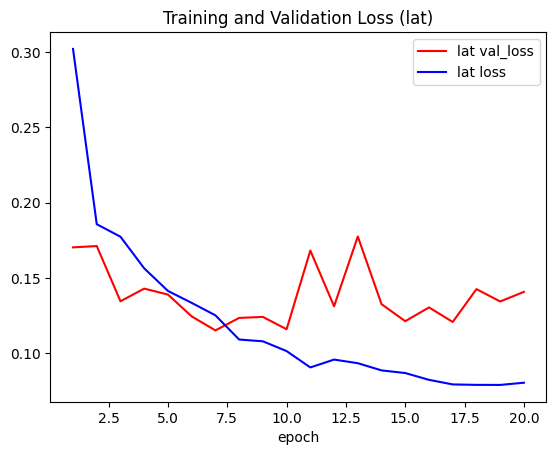

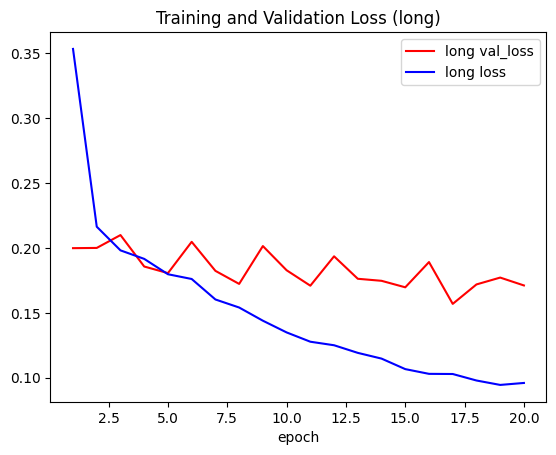

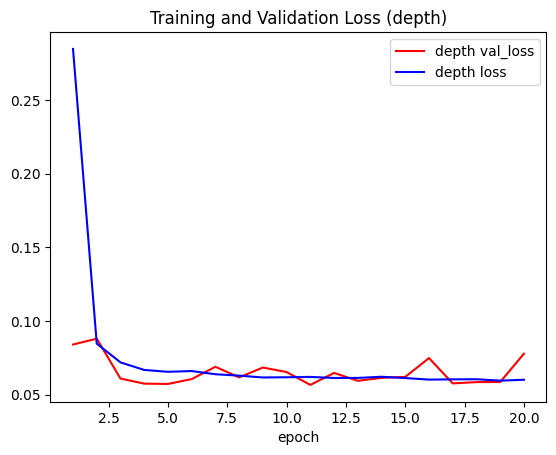

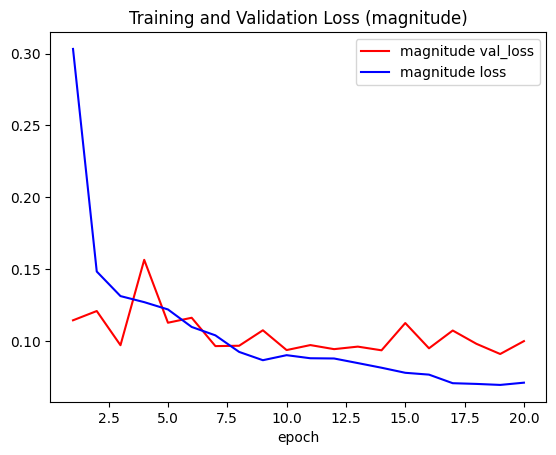

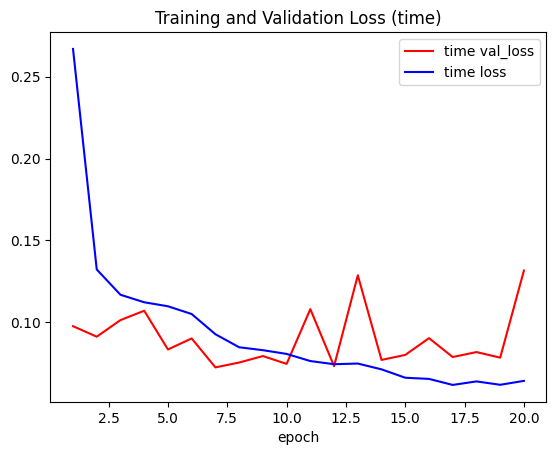

In [74]:
for output_name in y_train.keys():
    val_y = history.history["val_{}_loss".format(output_name)]
    train_y = history.history["{}_loss".format(output_name)]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.show()

In [75]:
test_eval = model.evaluate(x_test, y_test, batch_size=batch_size)
if len(y_test.keys())<=1:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        print(text_to_write)
else:
  for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
    text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
    print(text_to_write)



186/186 [==============================] - 2s 9ms/step
mae All : 0.6208882940712795
mae lat : 0.14067935943603516
mae long : 0.17114190757274628
mae depth : 0.0778290331363678
mae magnitude : 0.10007132589817047
mae time : 0.13155053555965424


In [76]:
predictions = model.predict(x_test, batch_size=batch_size)
predictions = np.array(predictions)

In [77]:
predictions.shape

(5, 186, 1)

In [78]:
x_test.shape

(186, 3000, 3)

In [79]:
len(y_test.keys())

5

In [80]:
result = pd.DataFrame(columns=['norm_lat','norm_long','norm_depth','norm_magnitude','norm_time'])

In [81]:
result

Empty DataFrame
Columns: [norm_lat, norm_long, norm_depth, norm_magnitude, norm_time]
Index: []

In [82]:
for prediction,col_result in zip(predictions,['norm_'+y_name for y_name in y_test.keys()]):
  result[col_result] = prediction.squeeze()

In [83]:
result

norm_lat  norm_long  norm_depth  norm_magnitude  norm_time
0    0.498732   0.222519    0.213129        0.247449   0.346504
1    0.419991   0.550162    0.110394        0.237833   0.296654
2    0.298147   0.657378    0.161957        0.239379   0.447544
3    0.415223   0.541335    0.113426        0.257511   0.317710
4    0.620234   0.585405    0.115018        0.125795   0.220465
..        ...        ...         ...             ...        ...
181  0.618477   0.356732    0.229079        0.166570   0.301516
182  0.188060   0.702626    0.180605        0.171567   0.488939
183  0.554616   0.247827    0.165443        0.130270   0.258402
184  0.351987   0.509185    0.135618        0.264072   0.387592
185  0.509406   0.660706    0.138691        0.201114   0.341396

[186 rows x 5 columns]

In [84]:
max_,min_ = {},{}
max_['lat'] = -6.64264
min_['lat'] = -11.5152
max_['long'] = 115.033
min_['long'] = 111.532
max_['depth'] = 588.426
min_['depth'] = 1.16
max_['magnitude'] = 6.5
min_['magnitude'] = 3.0
max_['time'] = 74.122
min_['time'] = 4.502

In [85]:
result.keys()

Index(['norm_lat', 'norm_long', 'norm_depth', 'norm_magnitude', 'norm_time'], dtype='object')

In [86]:
for col in result.keys():
  c_ = col.split("_")[-1]
  print(col)

norm_lat
norm_long
norm_depth
norm_magnitude
norm_time


In [87]:
# Denorm
for col in result.keys():
    c_ = col.split("_")[-1]
    result['pred_'+col] = result[col].apply(lambda x: (x*(max_[c_] - min_[c_]))+min_[c_])

In [88]:
test_df

Unnamed: 0   No         filename        Date  Hr  Min  Sec       Lat  \
24           25   27  20100106_094408    6/1/2010   9   44    8  -8.56271   
42           43   45  20100211_220355   11/2/2010  22    3   55  -9.43068   
43           44   46  20100212_050421   12/2/2010   5    4   21 -10.07068   
48           51   53  20100222_085639  22/02/2010   8   56   39  -9.42112   
54           58   60  20100309_151502    9/3/2010  15   15    2  -9.66031   
..          ...  ...              ...         ...  ..  ...  ...       ...   
609         659  708  20170724_143816  24/07/2017  14   38   16  -8.07530   
610         660  709  20170728_090624  28/07/2017   9    6   24  -9.13236   
611         661  710  20170730_132247  30/07/2017  13   22   47 -10.20690   
616         666  715  20170910_044804   10/9/2017   4   48    4  -7.04644   
617         667  716  20170926_013646  26/09/2017   1   36   46  -8.68782   

        Long  Mag  GMJI  JAGI  PWJI  Unpick  Cluster  PA_start_real  \
24   113.106  3.3     0     0     0       0        1            197   
42   114.052  3.2     0     0     0       0       14            200   
43   113.794  4.0     0     0     0       0       14            199   
48   114.001  3.3     0     0     0       0       14            200   
54   113.929  3.3     0     0     0       0       14            200   
..       ...  ...   ...   ...   ...     ...      ...            ...   
609  113.087  3.6     0     0     0       0       13            200   
610  112.963  4.0     0     0     0       0        1            200   
611  114.947  4.6     0     0     0       0        7            200   
616  114.197  3.3     0     0     1       1        6            200   
617  113.241  3.3     0     0     0       0       16            200   

     flag_start  PA_start datetime  seconds           foldername   PA  \
24          272       275  00:15.9   15.892  20100106_094408crop  200   
42          275       275  00:19.2   19.193  20100211_220355crop  200   
43          274       275  00:27.1   27.069  20100212_050421crop  200   
48          275       275  00:17.5   17.542  20100222_085639crop  200   
54          275       275  00:21.0   20.997  20100309_151502crop  200   
..          ...       ...      ...      ...                  ...  ...   
609         275       275  00:24.4   24.415  20170724_143816crop  200   
610         275       275  00:18.4   18.408  20170728_090624crop  200   
611         275       275  00:31.3   31.255  20170730_132247crop  200   
616         275       275  00:23.0   22.998  20170910_044804crop  200   
617         275       275  00:13.2   13.214  20170926_013646crop  200   

     cluster_class  norm_lat  norm_long  norm_magnitude  norm_depth  \
24               0  0.605942   0.449586        0.085714    0.170054   
42              11  0.427808   0.719794        0.057143    0.013571   
43              11  0.296460   0.646101        0.285714    0.035483   
48              11  0.429770   0.705227        0.085714    0.089825   
54              11  0.380681   0.684662        0.085714    0.021992   
..             ...       ...        ...             ...         ...   
609             10  0.705974   0.444159        0.171429    0.246297   
610              0  0.489032   0.408740        0.285714    0.051840   
611              5  0.268504   0.975436        0.457143    0.061272   
616              4  0.917128   0.761211        0.085714    0.015167   
617             13  0.580266   0.488146        0.085714    0.161520   

     Depth(km)    time  norm_time  
24    101.0270  15.892   0.163602  
42      9.1300  19.193   0.211017  
43     21.9980  27.069   0.324145  
48     53.9110  17.542   0.187302  
54     14.0750  20.997   0.236929  
..         ...     ...        ...  
609   145.8020  24.415   0.286024  
610    31.6040  18.408   0.199741  
611    37.1432  31.255   0.384272  
616    10.0670  22.998   0.265671  
617    96.0150  13.214   0.125136  

[62 rows x 30 columns]

In [89]:
result[0:3]

norm_lat  norm_long  norm_depth  norm_magnitude  norm_time  pred_norm_lat  \
0  0.498732   0.222519    0.213129        0.247449   0.346504      -9.085098   
1  0.419991   0.550162    0.110394        0.237833   0.296654      -9.468769   
2  0.298147   0.657378    0.161957        0.239379   0.447544     -10.062462   

   pred_norm_long  pred_norm_depth  pred_norm_magnitude  pred_norm_time  
0      112.311039       126.323651             3.866072       28.625600  
1      113.458116        65.990915             3.832415       25.155026  
2      113.833480        96.272030             3.837827       35.659997

In [90]:
test_df.loc[24:243].iloc[:, 7:].drop(columns=['GMJI','JAGI','PWJI','Unpick','Cluster','PA_start_real','flag_start','PA_start','datetime','foldername','PA','cluster_class','norm_lat','norm_long','norm_magnitude','norm_depth'])

Lat     Long  Mag  seconds  Depth(km)    time  norm_time
24   -8.56271  113.106  3.3   15.892   101.0270  15.892   0.163602
42   -9.43068  114.052  3.2   19.193     9.1300  19.193   0.211017
43  -10.07068  113.794  4.0   27.069    21.9980  27.069   0.324145
48   -9.42112  114.001  3.3   17.542    53.9110  17.542   0.187302
54   -9.66031  113.929  3.3   20.997    14.0750  20.997   0.236929
76   -9.24607  114.232  3.8   14.443     9.6350  14.443   0.142789
77   -8.27014  111.825  3.8   18.679   131.8060  18.679   0.203634
90   -9.68566  114.055  4.5   18.119     6.6650  18.119   0.195590
101  -9.32163  112.580  3.7   24.747    54.7830  24.747   0.290793
109  -9.45480  112.762  4.1   23.451    86.9540  23.451   0.272178
124  -8.83391  113.755  3.5   14.816    71.1060  14.816   0.148147
132  -8.80701  112.481  3.7   18.157    42.2320  18.157   0.196136
142  -8.83096  112.497  3.7   17.180    54.1490  17.180   0.182103
145  -8.64956  111.715  3.0   15.355    65.8230  15.355   0.155889
196  -9.16332  113.268  4.7   16.857    20.3000  16.857   0.177463
205  -9.68587  112.904  3.8   21.156    47.2839  21.156   0.239213
206  -9.34502  113.478  3.3   19.371    14.1750  19.371   0.213574
211 -10.74221  113.835  4.6   38.666    60.6000  38.666   0.490721
216 -10.79612  113.841  4.9   39.648    37.3430  39.648   0.504826
242 -10.79783  113.741  4.7   31.005    49.5560  31.005   0.380681

#LSTM

In [32]:
base="lstm"
output_names=["lat","long","depth","magnitude","time"]
model_name = base.upper() + "_multioutput_" if len(output_names)>1 else base.upper() + "_singleoutput_"  
model_name = model_name + "_".join(output_names) 
model_name

'LSTM_multioutput_lat_long_depth_magnitude_time'

In [33]:
custom_name = "base1024-64" 

In [35]:
import keras
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, LSTM
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

loss_function = 'mae'

def make_model(base="", output_names=[], custom_name=custom_name, loss_function=loss_function):
    m_ = None
    outputs = {}
    model_name = base.upper() + "_multioutput_" if len(output_names)>1 else base.upper() + "_singleoutput_"  
    model_name = model_name + "_".join(output_names) + "_"

    if base.lower()=="lstm":
        ### FOR CNN MODELS ###
        import keras
        base_model = Sequential()
        base_model.add(Conv1D(32, 3, input_shape=(x_test.shape[1], 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling1D(pool_size=2))
        base_model.add(LSTM(32, return_sequences = True)) 

        base_model.add(Conv1D(64, 3))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling1D(pool_size=2))
        base_model.add(LSTM(64, return_sequences = True)) 

        base_model.add(Conv1D(128, 3))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling1D(pool_size=2))
        base_model.add(LSTM(128, return_sequences = True)) 

        base_model.add(Conv1D(256, 3))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling1D(pool_size=2))
        base_model.add(LSTM(256, return_sequences = True)) 


### TUNNING SHARED-LAYER
        base_model.add(Flatten()) 
#         base_model.add(Dense(1024, kernel_initializer=keras.initializers.Orthogonal()))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
#         base_model.add(Dense(1024, kernel_initializer=keras.initializers.Orthogonal()))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
#         base_model.add(Dense(1024, kernel_initializer=keras.initializers.Orthogonal()))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
        m_ = base_model.output
        print(m_)


    else:
        print("Model Definition Error")

### NON-SHARED-LAYER
    for output_name in output_names:
        # multioutput
        m__ = m_
#         m__ = Dense(512,activation='relu')(m__) 
#         m__ = Dense(512,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m__) 
#         m__ = Dense(256,activation='relu')(m__) 
#         m__ = Dense(256,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m__) 
        outputs[output_name] = Dense(1, activation = 'linear', name = output_name)(m__)
        
    if len(output_names)==0: print("Outputs Definition Error")
    else:
        # single output 
        model = Model(inputs=base_model.input, outputs=[outputs[output_name] for output_name in output_names]) 
    
    model.compile(optimizer=Adam(1e-4),
                  loss=loss_function,   
                  metrics=[loss_function])
    
    model.summary()
    return model

In [36]:
model = make_model(base="lstm", output_names=["lat","long","depth","magnitude","time"])
y_train = {'lat':y_lat_train,'long':y_long_train,'depth':y_depth_train,'magnitude':y_magnitude_train,'time':y_time_train}
y_valid = {'lat':y_lat_test,'long':y_long_test,'depth':y_depth_test,'magnitude':y_magnitude_test,'time':y_time_test}
y_test = {'lat':y_lat_test,'long':y_long_test,'depth':y_depth_test,'magnitude':y_magnitude_test,'time':y_time_test}
model.name

Tensor("activation_7/Relu:0", shape=(None, 1024), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_1_input (InputLayer)     (None, 3000, 3)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2998, 32)     320         conv1d_1_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2998, 32)     128         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 2998, 32)     0           batch_normalization_1[0][0]      
___________________________

'model_1'

In [37]:
NSTEP = 20
Nbatch = 4

In [38]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.00001,
              verbose=1)

checkpoint = ModelCheckpoint( model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [39]:
history = model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=epochs, batch_size=batch_size)

Train on 1668 samples, validate on 186 samples
Epoch 1/20
1668/1668 [==============================] - 1012s 607ms/step - loss: 0.7820 - lat_loss: 0.1891 - long_loss: 0.2148 - depth_loss: 0.0953 - magnitude_loss: 0.1471 - time_loss: 0.1357 - lat_mae: 0.1891 - long_mae: 0.2148 - depth_mae: 0.0953 - magnitude_mae: 0.1471 - time_mae: 0.1357 - val_loss: 0.6620 - val_lat_loss: 0.1509 - val_long_loss: 0.2190 - val_depth_loss: 0.0703 - val_magnitude_loss: 0.1210 - val_time_loss: 0.0991 - val_lat_mae: 0.1519 - val_long_mae: 0.2198 - val_depth_mae: 0.0707 - val_magnitude_mae: 0.1209 - val_time_mae: 0.0987
Epoch 2/20
1668/1668 [==============================] - 975s 584ms/step - loss: 0.6188 - lat_loss: 0.1523 - long_loss: 0.1764 - depth_loss: 0.0668 - magnitude_loss: 0.1178 - time_loss: 0.1056 - lat_mae: 0.1523 - long_mae: 0.1764 - depth_mae: 0.0668 - magnitude_mae: 0.1178 - time_mae: 0.1056 - val_loss: 0.6394 - val_lat_loss: 0.1945 - val_long_loss: 0.1860 - val_depth_loss: 0.0613 - val_magnitu

In [40]:
model.history

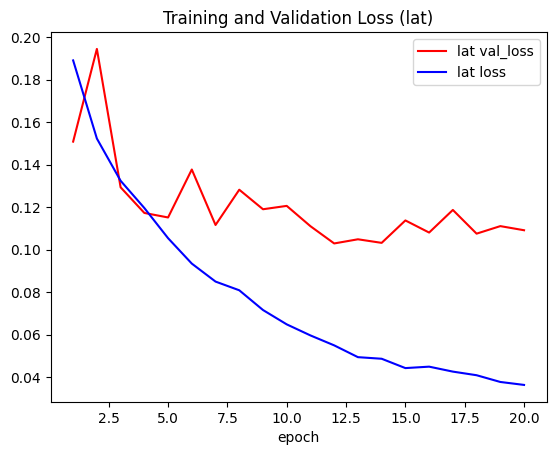

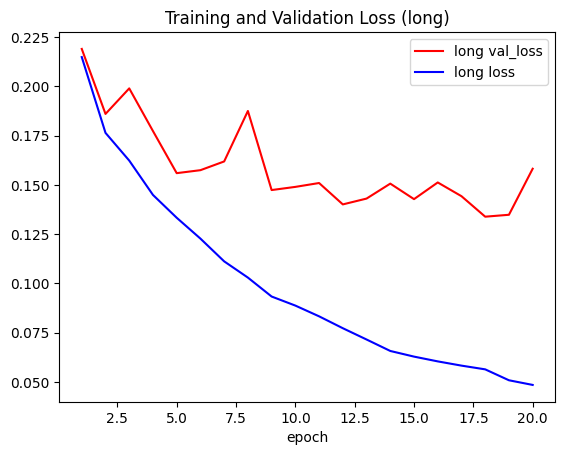

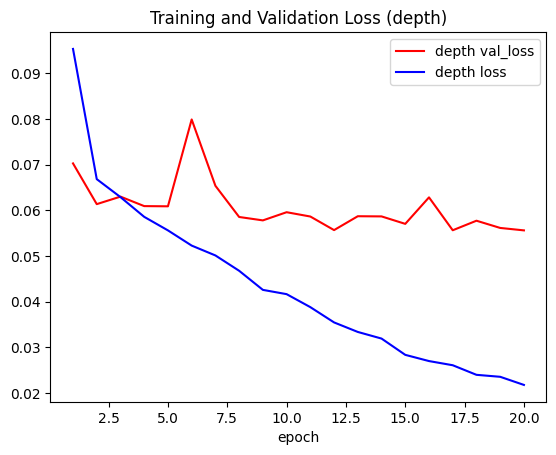

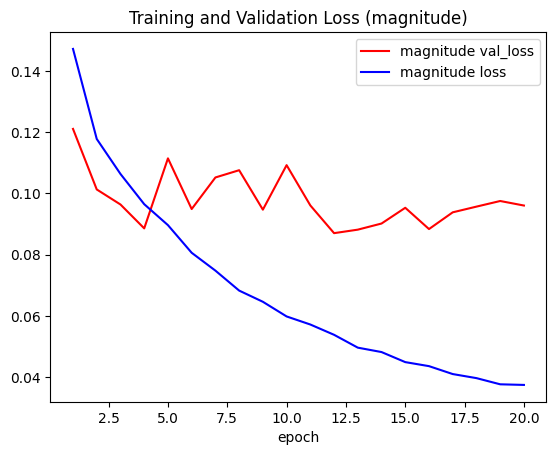

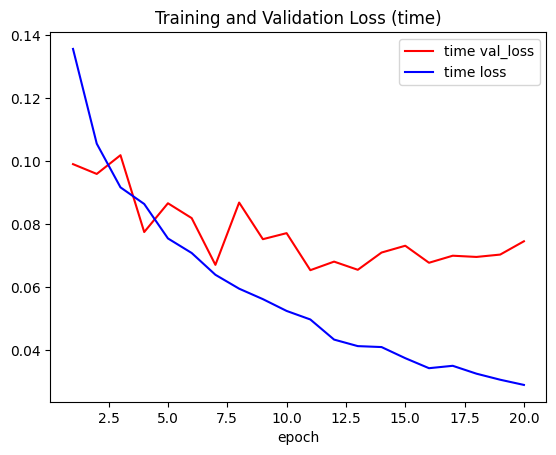

In [41]:
for output_name in y_train.keys():
    val_y = history.history["val_{}_loss".format(output_name)]
    train_y = history.history["{}_loss".format(output_name)]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.show()

In [42]:
test_eval = model.evaluate(x_test, y_test, batch_size=batch_size)
if len(y_test.keys())<=1:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        print(text_to_write)
else:
  for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
    text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
    print(text_to_write)

186/186 [==============================] - 14s 78ms/step
mae All : 0.49294909802816245
mae lat : 0.10914788395166397
mae long : 0.15815505385398865
mae depth : 0.055592022836208344
mae magnitude : 0.0960463359951973
mae time : 0.07456310838460922


In [57]:
model.save_weights("CNN_LSTM"+"_SWA.h5")

In [44]:
predictions = model.predict(x_test, batch_size=batch_size)
predictions = np.array(predictions)

In [45]:
result = pd.DataFrame(columns=['norm_lat','norm_long','norm_depth','norm_magnitude','norm_time'])

In [51]:
for prediction,col_result in zip(predictions,['norm_'+y_name for y_name in y_test.keys()]):
  result[col_result] = prediction.squeeze()

In [47]:
max_,min_ = {},{}
max_['lat'] = -6.64264
min_['lat'] = -11.5152
max_['long'] = 115.033
min_['long'] = 111.532
max_['depth'] = 588.426
min_['depth'] = 1.16
max_['magnitude'] = 6.5
min_['magnitude'] = 3.0
max_['time'] = 74.122
min_['time'] = 4.502

In [48]:
# Denorm
for col in result.keys():
    c_ = col.split("_")[-1]
    result['pred_'+col] = result[col].apply(lambda x: (x*(max_[c_] - min_[c_]))+min_[c_])

In [53]:
result[0: 12]

norm_lat  norm_long  norm_depth  norm_magnitude  norm_time  pred_norm_lat  \
0   0.509255   0.391382    0.113696        0.061917   0.201403      -9.033827   
1   0.393667   0.457280    0.060602        0.235842   0.290112      -9.597035   
2   0.445027   0.521468    0.090621        0.148113   0.254647      -9.346779   
3   0.289258   0.688411    0.127980        0.265334   0.410628     -10.105775   
4   0.426671   0.788024    0.025381        0.138781   0.173562      -9.436220   
5   0.395736   0.582575    0.098414        0.126500   0.261094      -9.586952   
6   0.355325   0.749390    0.079590        0.212098   0.292965      -9.783860   
7   0.477103   0.709377    0.134795        0.190367   0.297496      -9.190486   
8   0.366488   0.467317    0.115646        0.225594   0.373444      -9.729463   
9   0.389590   0.483759    0.077849        0.174181   0.280382      -9.616900   
10  0.475072   0.787121    0.048395        0.145885   0.218601      -9.200385   
11  0.485299   0.655529    0.093983        0.166753   0.219673      -9.150554   

    pred_norm_long  pred_norm_depth  pred_norm_magnitude  pred_norm_time  
0       112.902230        67.929783             3.216710       18.523686  
1       113.132938        36.749519             3.825446       24.699630  
2       113.357660        54.378826             3.518397       22.230521  
3       113.942128        76.318465             3.928667       33.089952  
4       114.290871        16.065185             3.485735       16.585421  
5       113.571597        58.955089             3.442751       22.679336  
6       114.155616        47.900291             3.742344       24.898223  
7       114.015527        80.320351             3.666283       25.213661  
8       113.168078        69.075028             3.789578       30.501196  
9       113.225640        46.878084             3.609632       24.022164  
10      114.287710        29.580651             3.510598       19.721017  
11      113.827007        56.353039             3.583634       19.795610

In [56]:
print(len(result))
print(len(test_df))

186
62


In [50]:
test_df.loc[24:243].iloc[:, 7:].drop(columns=['GMJI','JAGI','PWJI','Unpick','Cluster','PA_start_real','flag_start','PA_start','datetime','foldername','PA','cluster_class','norm_lat','norm_long','norm_magnitude','norm_depth'])

Lat     Long  Mag  seconds  Depth(km)    time  norm_time
24   -8.56271  113.106  3.3   15.892   101.0270  15.892   0.163602
42   -9.43068  114.052  3.2   19.193     9.1300  19.193   0.211017
43  -10.07068  113.794  4.0   27.069    21.9980  27.069   0.324145
48   -9.42112  114.001  3.3   17.542    53.9110  17.542   0.187302
54   -9.66031  113.929  3.3   20.997    14.0750  20.997   0.236929
76   -9.24607  114.232  3.8   14.443     9.6350  14.443   0.142789
77   -8.27014  111.825  3.8   18.679   131.8060  18.679   0.203634
90   -9.68566  114.055  4.5   18.119     6.6650  18.119   0.195590
101  -9.32163  112.580  3.7   24.747    54.7830  24.747   0.290793
109  -9.45480  112.762  4.1   23.451    86.9540  23.451   0.272178
124  -8.83391  113.755  3.5   14.816    71.1060  14.816   0.148147
132  -8.80701  112.481  3.7   18.157    42.2320  18.157   0.196136
142  -8.83096  112.497  3.7   17.180    54.1490  17.180   0.182103
145  -8.64956  111.715  3.0   15.355    65.8230  15.355   0.155889
196  -9.16332  113.268  4.7   16.857    20.3000  16.857   0.177463
205  -9.68587  112.904  3.8   21.156    47.2839  21.156   0.239213
206  -9.34502  113.478  3.3   19.371    14.1750  19.371   0.213574
211 -10.74221  113.835  4.6   38.666    60.6000  38.666   0.490721
216 -10.79612  113.841  4.9   39.648    37.3430  39.648   0.504826
242 -10.79783  113.741  4.7   31.005    49.5560  31.005   0.380681

#test predict

In [ ]:
df.loc[587, "filename"]

'20170428_014929'

In [ ]:
##generate dataset untuk p_arrive dan waveform
lst_test = []
data_test = generate_dataset(df.loc[587, "filename"])
###lst_total.append(generate_waveform(data_setpoint))


In [ ]:
data_test

starttime  \
id                                                  
20170428_014929_GMJI  2017-04-28T01:47:22.712500Z   
20170428_014929_JAGI  2017-04-28T01:47:17.819538Z   
20170428_014929_PWJI  2017-04-28T01:47:28.712500Z   

                                          endtime   npts  \
id                                                         
20170428_014929_GMJI  2017-04-28T02:04:31.887500Z  20584   
20170428_014929_JAGI  2017-04-28T02:04:39.769538Z  20840   
20170428_014929_PWJI  2017-04-28T02:04:33.387500Z  20495   

                                                             E_waveform  \
id                                                                        
20170428_014929_GMJI  [0.004061194678609446, -0.004809753773015695, ...   
20170428_014929_JAGI  [4.7444277374745624e-05, -0.04043321067304826,...   
20170428_014929_PWJI  [-0.00011042039825147285, 0.006084686919490986...   

                                                             N_waveform  \
id                                                                        
20170428_014929_GMJI  [-0.001303074152310275, -0.01390715548520482, ...   
20170428_014929_JAGI  [6.361491207346572e-05, 0.03621684188116532, 0...   
20170428_014929_PWJI  [0.0003809156398222021, 0.017968859624704576, ...   

                                                             Z_waveform  \
id                                                                        
20170428_014929_GMJI  [-0.0038584916706377466, 0.07109029747295026, ...   
20170428_014929_JAGI  [-0.0006610779094371572, 0.05497202737312852, ...   
20170428_014929_PWJI  [0.00017418810312843977, -0.03382815582886325,...   

                                   p_arrival_time  \
id                                                  
20170428_014929_GMJI  2017-04-28T01:49:58.224000Z   
20170428_014929_JAGI  2017-04-28T01:49:58.224000Z   
20170428_014929_PWJI  2017-04-28T01:49:45.024000Z   

                                   s_arrival_time p_arrival_sample  \
id                                                                   
20170428_014929_GMJI  2017-04-28T01:50:21.751000Z             3110   
20170428_014929_JAGI  2017-04-28T01:50:21.751000Z             3208   
20170428_014929_PWJI  2017-04-28T01:49:58.342000Z             2726   

                     s_arrival_sample network station location  sampling_rate  \
id                                                                              
20170428_014929_GMJI             3581      IA    GMJI                    20.0   
20170428_014929_JAGI             3679      IA    JAGI                    20.0   
20170428_014929_PWJI             2993      IA    PWJI                    20.0   

                      delta  calib  
id                                  
20170428_014929_GMJI   0.05    1.0  
20170428_014929_JAGI   0.05    1.0  
20170428_014929_PWJI   0.05    1.0

In [ ]:
generate_waveforms_with_interpolate(data_test, lst_test)

In [ ]:
lst_test = np.array(lst_test)
lst_test.shape

(3, 3000, 3)

In [ ]:
pred_test = model.predict(lst_test, batch_size=batch_size)
pred_test = np.array(pred_test)

1/1 [==============================] - 0s 80ms/step


In [ ]:
result_test = pd.DataFrame(columns=['norm_lat','norm_long','norm_depth','norm_magnitude','norm_time'])

In [ ]:
result_test

Empty DataFrame
Columns: [norm_lat, norm_long, norm_depth, norm_magnitude, norm_time]
Index: []

In [ ]:
for prediction,col_result in zip(pred_test,['norm_'+y_name for y_name in y_test.keys()]):
  result_test[col_result] = prediction.squeeze()

In [ ]:
for col in result_test.keys():
    c_ = col.split("_")[-1]
    result_test['pred_'+col] = result_test[col].apply(lambda x: (x*(max_[c_] - min_[c_]))+min_[c_])

In [ ]:
result_test

norm_lat  norm_long  norm_depth  norm_magnitude  norm_time  pred_norm_lat  \
0  0.879807   0.048594    0.050507        0.106257   0.118524      -7.228290   
1  0.821056   0.062110    0.056301        0.098612   0.126602      -7.514556   
2  0.721377   0.102466    0.063467        0.090643   0.141440      -8.000245   

   pred_norm_long  pred_norm_depth  pred_norm_magnitude  pred_norm_time  
0      111.702129        30.821010             3.371898       12.753637  
1      111.749448        34.223552             3.345142       13.316047  
2      111.890735        38.431768             3.317251       14.349068

In [ ]:
df.loc[587:587].iloc[:, 7:].drop(columns=['GMJI','JAGI','PWJI','Unpick','Cluster','PA_start_real','flag_start','PA_start','datetime','foldername','PA','cluster_class','norm_lat','norm_long','norm_magnitude','norm_time'])

Lat     Long  Mag  seconds  norm_depth  Depth(km)    time
587 -8.08697  111.716  3.4   16.024    0.214165    126.932  16.024